# Precios internacionales de cultivos (COMTRADE vs. WB)

Se calculan los precios de cultivos que exporta la Argentina usando la API de COMTRADE y se compara su evolución con precios internacionales extraídos de la API de WB.

In [22]:
import pandas as pd
import requests
import json
import matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")

## COMTRADE

La base de datos de comercio exterior de Naciones Unidas (UN COMTRADE - https://comtrade.un.org/) contiene datos de importación/exportación (valores monetarios y, en muchos casos, cantidades) entre países del mundo, con varias décadas de datos disponibles (a veces desde los 60's/70's). 

Una forma de calcular los precios que recibe la Argentina por la exportación de algunos de sus cultivos, es tomar los datos de COMTRADE y dividir valor exportado por cantidades exportadas. Esto tiene la ventaja de ser (potencialmente) un precio de efecto algo más representativo para el país exportador (pero cuidado! no siempre funciona bien).

A continuación construimos estos *precios promedio* para Soja y Trigo con datos de COMTRADE, para compararlos más adelante con precios internacionales de una base del Banco Mundial.

In [23]:
API_COMTRADE = "http://comtrade.un.org/api/get"

In [24]:
params = {
    "freq": "A", # frecuencia anual
    "r": 32, # reporter (reporta los datos): 32 es el código de la Argentina
    "ps": "ALL", # período (any para tomar todos los años)
    "px": "S1", # sistema de clasificación de productos: SITC Rev 1 es la serie más larga
    "fmt": "JSON", # formato devuelto (CSV o JSON)
    "p": 0, # partner (contraparte comercial del reporter): 0 es el código del Mundo
    "rg": 2, # 1: importaciones, 2: exportaciones
    "cc": "2214,041", # commodity code: 2214 "Soya" / 041 "Wheat" / 4216 "Sunflower" / 044 "Corn"
    "max": 50000, # cantidad máxima de resultados (50.000 es un máximo absoluto)
    "head": "H", # M: machine readable headers, H: human readable headers
}

In [25]:
# si internet funciona
# res = requests.get(API_COMTRADE, params=params)
# json_res = res.json()

# si internet no funciona
with open("data/comtrade-cultivos-principales.json", "rb") as f:
    json_res = json.load(f)

In [26]:
df_comtrade = pd.DataFrame(json_res["dataset"])

In [9]:
df_comtrade.head(3)

,AltQuantity,CIFValue,FOBValue,GrossWeight,IsLeaf,NetWeight,TradeQuantity,TradeValue,aggrLevel,cmdCode,...,qtAltCode,qtAltDesc,qtCode,qtDesc,rgCode,rgDesc,rt3ISO,rtCode,rtTitle,yr
0,None,None,None,None,0,2832336128,2832336128,173363088,3,041,...,None,,8,Weight in kilograms,2,Export,ARG,32,Argentina,1962
1,None,None,None,None,0,1830655616,1830655616,116388784,3,041,...,None,,8,Weight in kilograms,2,Export,ARG,32,Argentina,1963
2,None,None,None,None,0,3710008576,3710008576,242256288,3,041,...,None,,8,Weight in kilograms,2,Export,ARG,32,Argentina,1964


In [27]:
df_comtrade.head(3).transpose()

,0,1,2
estCode,0,0,0
aggrLevel,3,3,3
AltQuantity,None,None,None
rgCode,2,2,2
period,1962,1963,1964
rtCode,32,32,32
FOBValue,None,None,None
cmdCode,041,041,041
cstDesc,,,
rt3ISO,ARG,ARG,ARG


In [19]:
columns = ["rgDesc", "rtTitle", "ptTitle", "yr",
           "cmdCode", "cmdDescE", "TradeValue", "TradeQuantity", "qtDesc"]

In [28]:
df_comtrade[columns].head(5)

,rgDesc,rtTitle,ptTitle,yr,cmdCode,cmdDescE,TradeValue,TradeQuantity,qtDesc
0,Export,Argentina,World,1962,041,"Wheat including spelt and meslin, unmilled",173363088,2832336128,Weight in kilograms
1,Export,Argentina,World,1963,041,"Wheat including spelt and meslin, unmilled",116388784,1830655616,Weight in kilograms
2,Export,Argentina,World,1964,041,"Wheat including spelt and meslin, unmilled",242256288,3710008576,Weight in kilograms
3,Export,Argentina,World,1965,041,"Wheat including spelt and meslin, unmilled",372666400,6660583936,Weight in kilograms
4,Export,Argentina,World,1966,041,"Wheat including spelt and meslin, unmilled",279624704,5054666240,Weight in kilograms


In [29]:
df_comtrade["precio_ton"] = df_comtrade.TradeValue / df_comtrade.TradeQuantity * 1000

In [30]:
precios_soja = df_comtrade[df_comtrade.cmdCode == "2214"][["yr", "precio_ton"]].sort_values("yr").set_index("yr")

,precio_ton
yr,
1964,180.000000
1966,75.130435
1968,203.924528
1972,461.538462
1974,878.400000
1975,305.250305
1976,206.460197
1977,297.440509
1978,229.348391


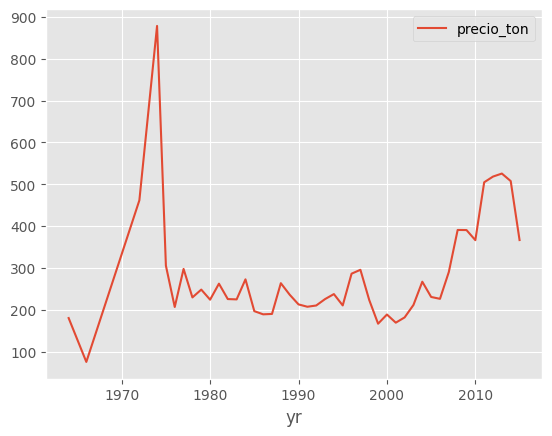

In [32]:
precios_soja.plot.line()
precios_soja


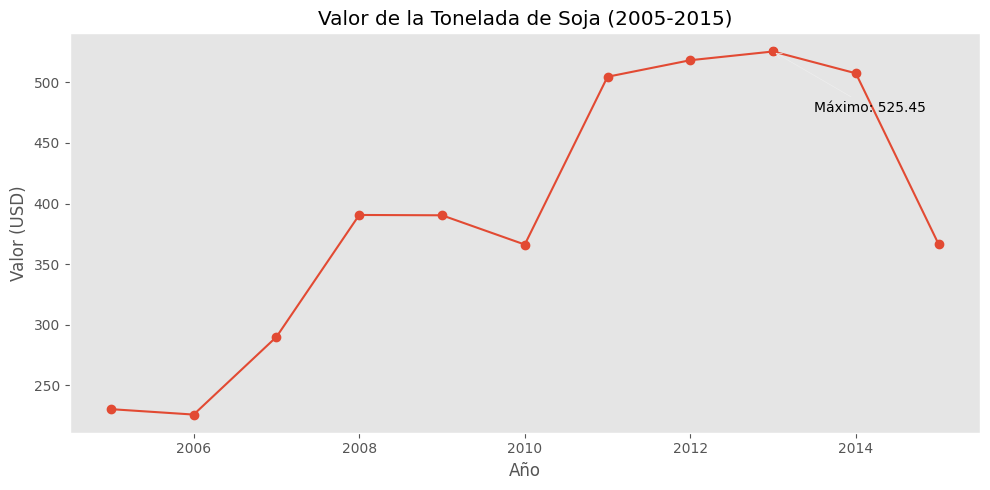

In [33]:
import matplotlib.pyplot as plt

# Datos
años = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
valores_soja = [
    230.441120,
    225.978790,
    290.061278,
    390.610502,
    390.346051,
    366.206840,
    504.611748,
    518.252314,
    525.449603,
    507.460665,
    366.511898
]

# Encuentra el valor máximo
valor_maximo = max(valores_soja)
año_maximo = años[valores_soja.index(valor_maximo)]

# Crear el gráfico
plt.figure(figsize=(10, 5))
plt.plot(años, valores_soja, marker='o')
plt.title('Valor de la Tonelada de Soja (2005-2015)')
plt.xlabel('Año')
plt.ylabel('Valor (USD)')
plt.grid()

# Marcar el valor máximo
plt.scatter(año_maximo, valor_maximo, color='red') # punto máximo en rojo
plt.annotate(f'Máximo: {valor_maximo:.2f}', 
             xy=(año_maximo, valor_maximo), 
             xytext=(año_maximo+0.5, valor_maximo-50),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [17]:
precios_trigo = df_comtrade[df_comtrade.cmdCode == "041"][["yr", "precio_ton"]].sort_values("yr").set_index("yr")

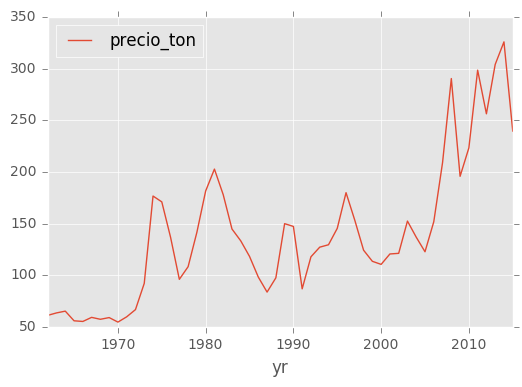

In [18]:
precios_trigo.plot.line()

## Banco Mundial

Ahora queremos sumar datos de precios internacionales de estos 2 cultivos a lo largo del tiempo. Usamos la API del Banco Mundial (https://datahelpdesk.worldbank.org/knowledgebase/topics/125589) para descargar precios internacionales de referencia.

### Buscamos un catálogo de commodities

In [19]:
res = requests.get("http://api.worldbank.org/sources?format=JSON")

In [20]:
df_sources_wb = pd.DataFrame(res.json()[1])

In [21]:
df_sources_wb.head(3)

,description,id,name,url
0,,11,Africa Development Indicators,
1,,36,Statistical Capacity Indicators,
2,,31,Country Policy and Institutional Assessment (C...,


In [22]:
df_sources_wb[df_sources_wb.name.str.contains("commodities", case=False)]

,description,id,name,url
15,,21,Global Economic Monitor (GEM) Commodities,


### Buscamos indicadores de cultivos

In [23]:
res = requests.get("http://api.worldbank.org/indicators?source=21&format=json&per_page=200")

In [24]:
df_indics_wb = pd.DataFrame(res.json()[1])

In [25]:
df_indics_wb.head(3)

,id,name,source,sourceNote,sourceOrganization,topics
0,ALUMINUM,"Aluminum, $/mt, current$","{u'id': u'21', u'value': u'Global Economic Mon...","Aluminum (LME) London Metal Exchange, unalloye...","Platts Metals Week, Thomson Reuters Datastream...",[]
1,BANANA_EU,"Bananas, EU, $/mt, current$","{u'id': u'21', u'value': u'Global Economic Mon...","Bananas (Central & South America), major brand...",Sopisco News; Union of Banana-Exporting Countr...,[]
2,BANANA_US,"Bananas, US, $/mt, current$","{u'id': u'21', u'value': u'Global Economic Mon...","Bananas (Central & South America), major brand...",Sopisco News; Union of Banana-Exporting Countr...,[]


In [26]:
df_indics_wb[df_indics_wb.name.str.contains("soybean", case=False)]

,id,name,source,sourceNote,sourceOrganization,topics
110,KSOYBEAN_MEAL,"Soybean meal, $/mt, constant 2000$","{u'id': u'21', u'value': u'Global Economic Mon...",,World Bank.,[]
111,KSOYBEAN_OIL,"Soybean oil, $/mt, constant 2000$","{u'id': u'21', u'value': u'Global Economic Mon...",,World Bank.,[]
112,KSOYBEANS,"Soybeans, $/mt, constant 2000$","{u'id': u'21', u'value': u'Global Economic Mon...",,World Bank.,[]
160,SOYBEAN_MEAL,"Soybean meal, $/mt, current$","{u'id': u'21', u'value': u'Global Economic Mon...","Soybean meal (any origin), Argentine 45/46% ex...","ISTA Mielke GmbH, Oil World; US Department of ...",[]
161,SOYBEAN_OIL,"Soybean oil, $/mt, current$","{u'id': u'21', u'value': u'Global Economic Mon...","Soybean oil (Any origin), crude, f.o.b. ex-mil...","ISTA Mielke GmbH, Oil World; US Department of ...",[]
162,SOYBEANS,"Soybeans, $/mt, current$","{u'id': u'21', u'value': u'Global Economic Mon...","Soybeans (US), c.i.f. Rotterdam","ISTA Mielke GmbH, Oil World; US Department of ...",[]


In [27]:
df_indics_wb[df_indics_wb.name.str.contains("wheat", case=False)]

,id,name,source,sourceNote,sourceOrganization,topics
128,KWHEAT_CANADI,"Wheat, Canada, $/mtv, constant 2000$","{u'id': u'21', u'value': u'Global Economic Mon...",,World Bank.,[]
129,KWHEAT_US_HRW,"Wheat, US, HRW, $/mt, constant 2000$","{u'id': u'21', u'value': u'Global Economic Mon...",,World Bank.,[]
130,KWHEAT_US_SRW,"Wheat, US, SRW, $/mt, constant 2000$","{u'id': u'21', u'value': u'Global Economic Mon...",,World Bank.,[]
178,WHEAT_CANADI,"Wheat, Canada, $/mt, current$","{u'id': u'21', u'value': u'Global Economic Mon...","Wheat (Canada), no. 1, Western Red Spring (CWR...",Canadian Grain Commission; Thomson Reuters Dat...,[]
179,WHEAT_US_HRW,"Wheat, US, HRW, $/mt, current$","{u'id': u'21', u'value': u'Global Economic Mon...","Wheat (US), no. 1, hard red winter, ordinary p...",Bloomberg; US Department of Agriculture; World...,[]
180,WHEAT_US_SRW,"Wheat, US, SRW, $/mt, current$","{u'id': u'21', u'value': u'Global Economic Mon...","Wheat (US), no. 2, soft red winter, export pri...",US Department of Agriculture; World Bank.,[]


### Buscamos datos de cada indicador

Los indicadores del WB que vamos a utilizar: "WHEAT_US_SRW" y "SOYBEANS".

#### Soja

In [44]:
API_WB_SOY = "http://api.worldbank.org/v2/es/countries/all/indicators/{}".format("SOYBEANS")
params_soy = {
    "format": "json",
    "per_page": 300,
    "source": 21
}

In [45]:
# si internet funciona
res = requests.get(API_WB_SOY, params=params_soy)
json_res = res.json()

In [46]:
df_wb_soy = pd.DataFrame(json_res[1])

In [47]:
df_wb_soy.head(5)

,country,countryiso3code,date,decimal,indicator,obs_status,unit,value
0,"{u'id': u'1W', u'value': u'World'}",,2015,0,"{u'id': u'SOYBEANS', u'value': u'Soybeans, $/m...",,,390.416667
1,"{u'id': u'1W', u'value': u'World'}",,2014,0,"{u'id': u'SOYBEANS', u'value': u'Soybeans, $/m...",,,491.770833
2,"{u'id': u'1W', u'value': u'World'}",,2013,0,"{u'id': u'SOYBEANS', u'value': u'Soybeans, $/m...",,,538.416667
3,"{u'id': u'1W', u'value': u'World'}",,2012,0,"{u'id': u'SOYBEANS', u'value': u'Soybeans, $/m...",,,591.416667
4,"{u'id': u'1W', u'value': u'World'}",,2011,0,"{u'id': u'SOYBEANS', u'value': u'Soybeans, $/m...",,,540.666667


In [48]:
precios_soja_wb = df_wb_soy[["date", "value"]].sort_values("date").set_index("date")

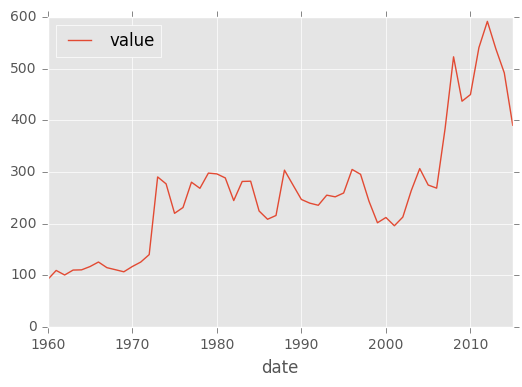

In [49]:
precios_soja_wb.plot.line()

In [50]:
precios_soja_wb.index = map(int, precios_soja_wb.index)

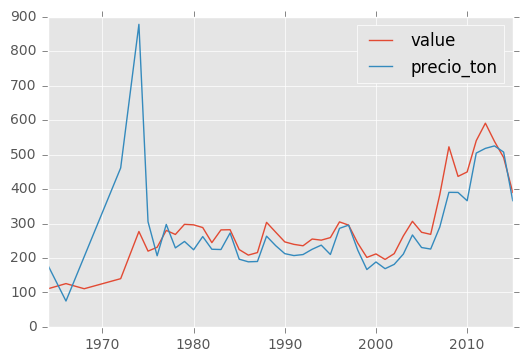

In [51]:
precios_soja_wb.merge(precios_soja, right_index=True, left_index=True).plot.line()

#### Trigo

In [52]:
API_WB_WHEAT = "http://api.worldbank.org/v2/es/countries/all/indicators/{}".format("WHEAT_US_SRW")
params_wheat = {
    "format": "json",
    "per_page": 300,
    "source": 21
}
res = requests.get(API_WB_WHEAT, params=params_wheat)
json_res = res.json()
df_wb_wheat = pd.DataFrame(json_res[1])

In [53]:
precios_trigo_wb = df_wb_wheat[["date", "value"]].sort_values("date").set_index("date")

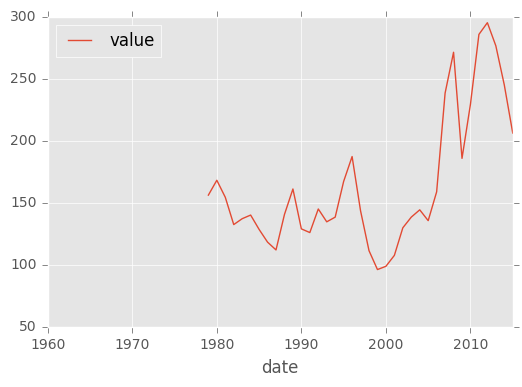

In [54]:
precios_trigo_wb.plot.line()

In [55]:
precios_trigo_wb.index = map(int, precios_trigo_wb.index)

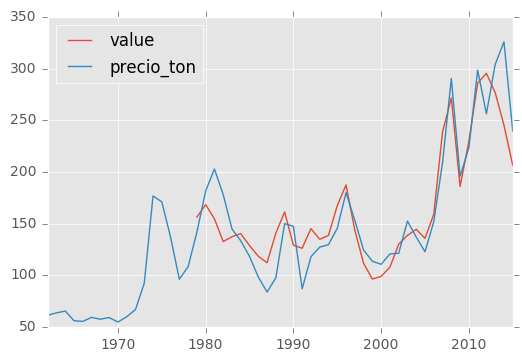

In [56]:
precios_trigo_wb.merge(precios_trigo, right_index=True, left_index=True).plot.line()

## Conclusiones

El precio calculado con datos de COMTRADE para el caso de un país exportador en particular, puede diferir bastante (en algunos años) del precio internacional, así que debe usarse con cuidado. Por este motivo el taller se desarrolló con datos de 1980 en adelante (el precio anterior de la soja calculado con COMTRADE no parece confiable). 

Dependiendo de para qué se necesite el dato (y de la disponibilidad de otras fuentes), puede ser mejor usar fuentes alternativas.